<a href="https://colab.research.google.com/github/chakri970/Stock-Market-Prediction/blob/main/correlation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
from textblob import TextBlob
from newsapi import NewsApiClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install newsapi-python textblob --quiet
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:






df_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mine/all_stocks_5yr.csv")
df_all['date'] = pd.to_datetime(df_all['date'])


newsapi = NewsApiClient(api_key='d69212dcd785498ca73674d72b617c2f')


selected_companies = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']


def get_sentiment_score(company):
    try:
        news = newsapi.get_everything(q=company, language='en', sort_by='relevancy', page_size=10)
        headlines = [article['title'] for article in news['articles']]
        scores = [TextBlob(h).sentiment.polarity for h in headlines]
        return round(np.mean(scores), 3) if scores else 0.0
    except:
        return 0.0

results = {'Company': [], 'RFR': [], 'LSTM': [], 'SA': [], 'Actual Close': []}

for company in selected_companies:
    df_company = df_all[df_all['Name'] == company].sort_values('date')

    if len(df_company) < 100:
        continue


    actual_close = df_company['close'].iloc[-1]


    rfr_df = df_company[['open', 'high', 'low', 'volume', 'close']]
    X = rfr_df.drop('close', axis=1)
    y = rfr_df['close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    rfr_model = RandomForestRegressor(n_estimators=50, random_state=42)
    rfr_model.fit(X_train, y_train)
    rfr_pred = rfr_model.predict([X_test.iloc[-1]])[0]

    # --- LSTM Prediction ---
    close_prices = df_company['close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(close_prices)

    lookback = 60
    if len(scaled_close) <= lookback:
        continue

    X_lstm, y_lstm = [], []
    for i in range(lookback, len(scaled_close)):
        X_lstm.append(scaled_close[i-lookback:i, 0])
        y_lstm.append(scaled_close[i, 0])
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model.fit(X_lstm, y_lstm, epochs=3, batch_size=32, verbose=0)

    lstm_input = scaled_close[-lookback:].reshape(1, lookback, 1)
    lstm_scaled_pred = lstm_model.predict(lstm_input)
    lstm_pred = scaler.inverse_transform(lstm_scaled_pred)[0][0]

    # --- Sentiment Analysis ---
    sa_score = get_sentiment_score(company)

    # --- Store Results ---
    results['Company'].append(company)
    results['RFR'].append(round(rfr_pred, 2))
    results['LSTM'].append(round(lstm_pred, 2))
    results['SA'].append(round(sa_score, 3))
    results['Actual Close'].append(round(actual_close, 2))

    print(f"{company} ➜ RFR: {rfr_pred:.2f}, LSTM: {lstm_pred:.2f}, SA: {sa_score:.3f}")

# Final DataFrame
df_results = pd.DataFrame(results)
print(df_results)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
AAPL ➜ RFR: 132.20, LSTM: 169.86, SA: -0.015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
AMZN ➜ RFR: 841.27, LSTM: 1423.09, SA: 0.209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
GOOG ➜ RFR: 897.58, LSTM: 1142.75, SA: 0.040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
MSFT ➜ RFR: 65.22, LSTM: 92.61, SA: 0.058
  Company     RFR         LSTM     SA  Actual Close
0    AAPL  132.20   169.860001 -0.015        159.54
1    AMZN  841.27  1423.089966  0.209       1416.78
2    GOOG  897.58  1142.750000  0.040       1048.58
3    MSFT   65.22    92.610001  0.058         89.61


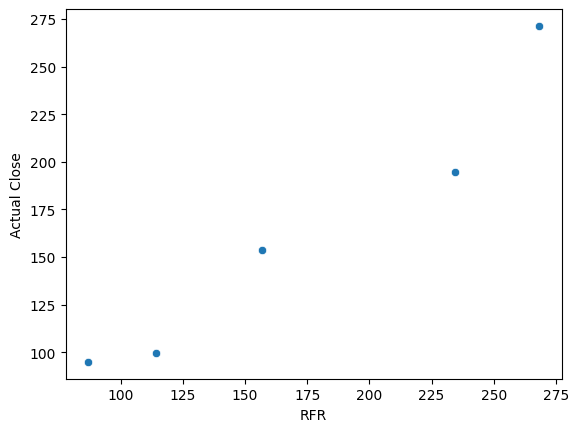

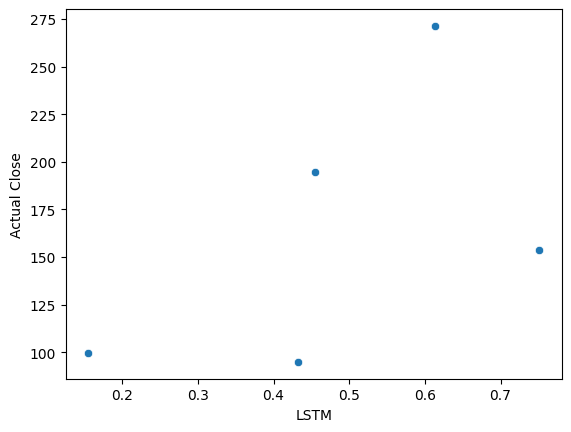

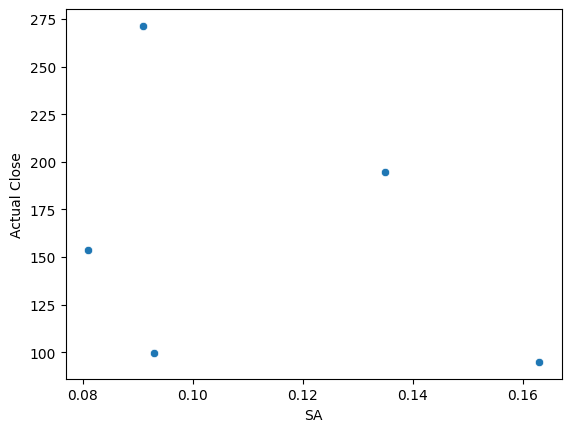

In [ ]:
sns.scatterplot(x='RFR', y='Actual Close', data=df)
plt.show()

sns.scatterplot(x='LSTM', y='Actual Close', data=df)
plt.show()

sns.scatterplot(x='SA', y='Actual Close', data=df)
plt.show()

In [ ]:
rfr_correlation = df['RFR'].corr(df['Actual Close'])
print("The correlation between RFR and Actual Close is:", rfr_correlation)

lstm_correlation = df['LSTM'].corr(df['Actual Close'])
print("The correlation between LSTM and Actual Close is:", lstm_correlation)

sa_correlation = df['SA'].corr(df['Actual Close'])
print("The correlation between SA and Actual Close is:", sa_correlation)

The correlation between RFR and Actual Close is: 0.9694748204715025
The correlation between LSTM and Actual Close is: 0.5349455238356787
The correlation between SA and Actual Close is: -0.34401024520175844
